In [5]:
import sys
from catboost import CatBoostClassifier, CatBoostRegressor
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
import xgboost as xgb
from xgboost import plot_importance
from ydata_profiling import ProfileReport

pd.set_option('display.max_columns', None)
# colors = ["#078533", "#850728", "#fcba03"]
sns.set_palette(sns.color_palette("Set2"))
print(f"Running on {sys.version}")

KAGGLE_ENV = False
GENERATE_REPORTS = False

# If we are running in a kaggle environment, then we need to use the kaggle
# provided data paths.
if KAGGLE_ENV:
    data_path = "../input/"
else:
    data_path = "./data/"

Running on 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]


In [8]:
df_train = pd.read_csv(data_path + "train.csv").drop(
    ["id"], axis=1
)
df_test = pd.read_csv(data_path + "test.csv")
test_IDs = df_test.id
df_test = df_test.drop("id", axis=1)
df_sample_sub = pd.read_csv(data_path + "sample_submission.csv")
df_supp = pd.read_csv(
    data_path + "cirrhosis.csv"
)[df_train.columns]

# Merge supplementary data
df_train = pd.concat(objs=[df_train, df_supp]).reset_index(drop=True)

LABEL = "Status"
CAT_FEATS = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
NUM_FEATS = [x for x in df_train.columns if x not in CAT_FEATS and x != LABEL]
ORG_FEATS = df_train.drop(LABEL, axis=1).columns.tolist() # original feats

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (8323, 19)
Test shape: (5271, 18)


# EDA | Descriptive Statistics

In [9]:
df_train

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8318,681,NaN,24472,F,NaN,NaN,NaN,N,1.2,NaN,2.96,NaN,NaN,NaN,NaN,174.0,10.9,3.0,D
8319,1103,NaN,14245,F,NaN,NaN,NaN,N,0.9,NaN,3.83,NaN,NaN,NaN,NaN,180.0,11.2,4.0,C
8320,1055,NaN,20819,F,NaN,NaN,NaN,N,1.6,NaN,3.42,NaN,NaN,NaN,NaN,143.0,9.9,3.0,C
8321,691,NaN,21185,F,NaN,NaN,NaN,N,0.8,NaN,3.75,NaN,NaN,NaN,NaN,269.0,10.4,3.0,C


In [10]:
%%time 
if GENERATE_REPORTS:
    # Generate the profile report
    profile = ProfileReport(df_train, title="YData Profiling Report - Cirrhosis")
    profile.to_notebook_iframe()

Wall time: 0 ns


In [11]:
desc_df = df_train.describe(include="all")
desc_df = desc_df.T
desc_df['unique'] = desc_df['unique'].fillna(df_train.nunique())
desc_df['count'] = desc_df['count'].astype('int16')
desc_df['missing'] = df_train.shape[0] - desc_df['count']
desc_df

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,missing
N_Days,8323,495,NaN,NaN,2024.528776,1094.968696,41.0,1220.0,1831.0,2689.0,4795.0,0
Drug,8217,2,Placebo,4164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106
Age,8323,397,NaN,NaN,18381.192359,3686.832308,9598.0,15574.0,18713.0,20684.0,28650.0,0
Sex,8323,2,F,7710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
Ascites,8217,2,N,7813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106
Hepatomegaly,8217,2,Y,4202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106
Spiders,8217,2,N,6188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106
Edema,8323,3,N,7515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
Bilirubin,8323,117,NaN,NaN,2.62594,3.847146,0.3,0.7,1.1,3.0,28.0,0
Cholesterol,8189,227,NaN,NaN,351.219074,196.775246,120.0,248.0,299.0,392.0,1775.0,134


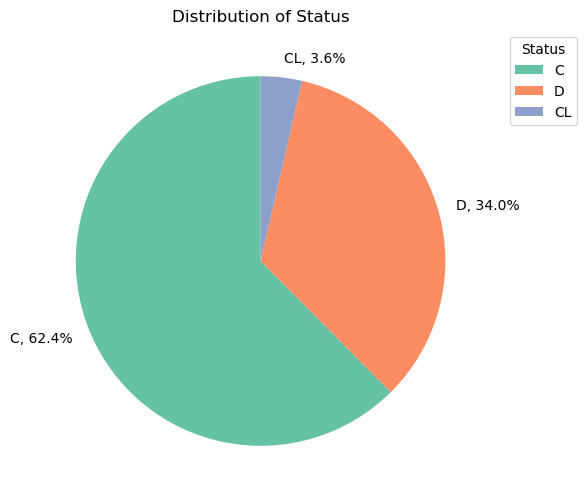

In [14]:

# Counting the observations for each category
status_counts = df_train[LABEL].value_counts()
labels = status_counts.index
sizes = status_counts.values

# Calculating the percentage of each category
percentages = 100.*sizes/sizes.sum()

# Creating the pie chart with percentages in the labels
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=[f"{l}, {s:.1f}%" for l, s in zip(labels, percentages)], startangle=90)
plt.gca().set_aspect("equal")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), labels=labels, title=LABEL)
plt.title(f"Distribution of {LABEL}")
plt.show()

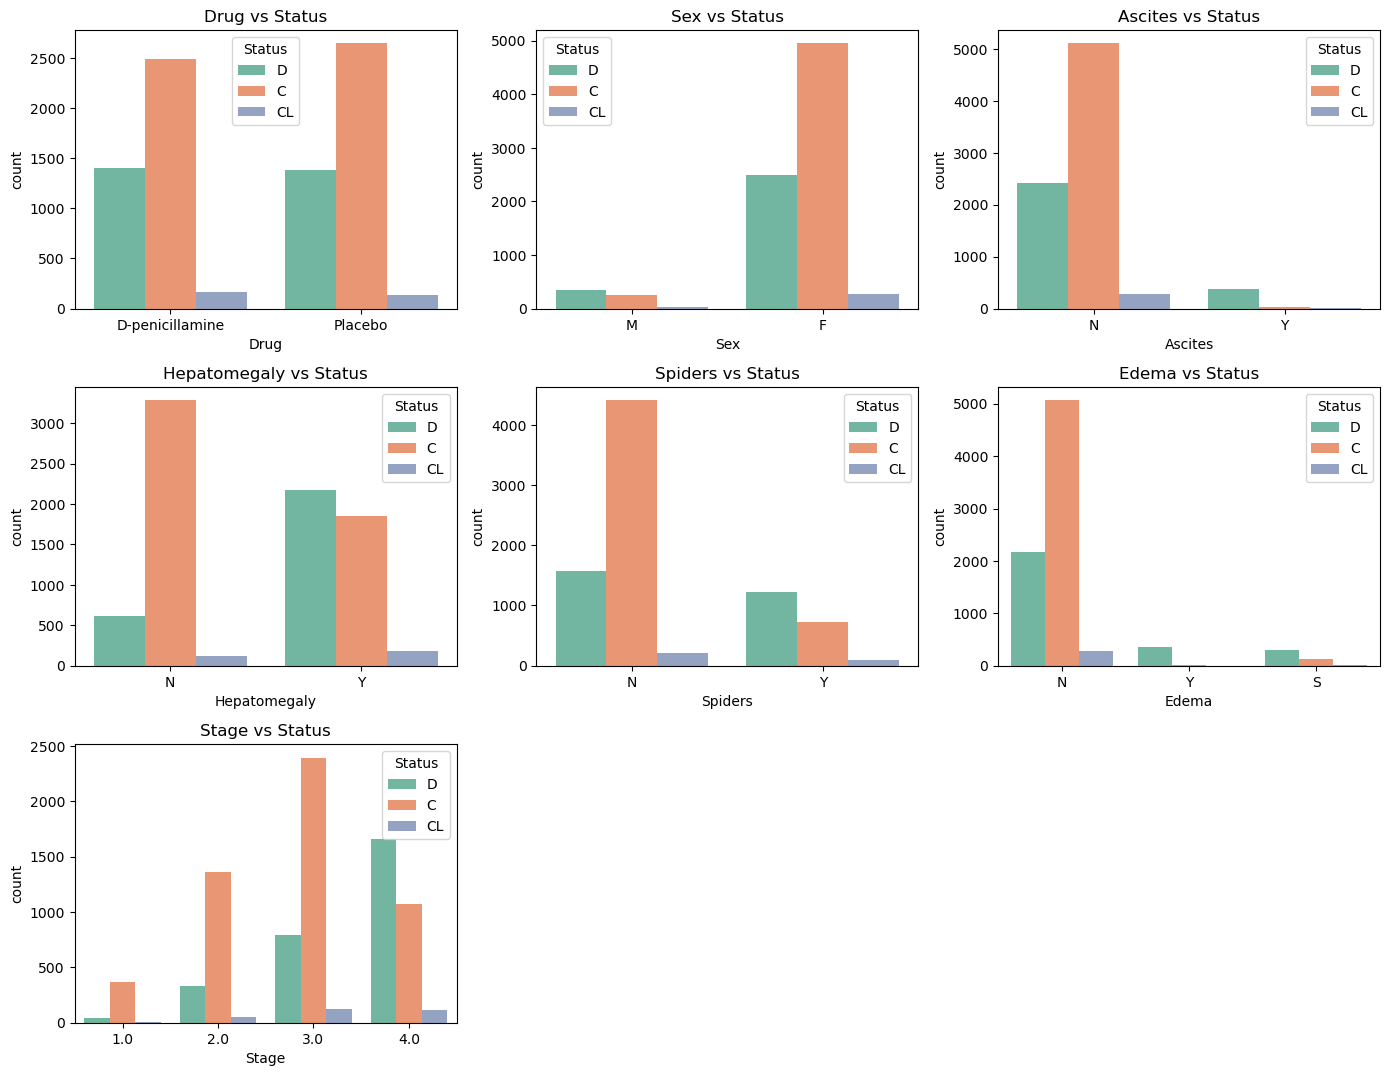

In [15]:
plt.figure(figsize=(14, len(CAT_FEATS) * 2))
for i, col in enumerate(CAT_FEATS):
    plt.subplot(len(CAT_FEATS) // 2 + 1, 3, i + 1)
    sns.countplot(x=col, hue=LABEL, data=df_train)
    plt.title(f"{col} vs {LABEL}")
    plt.tight_layout()

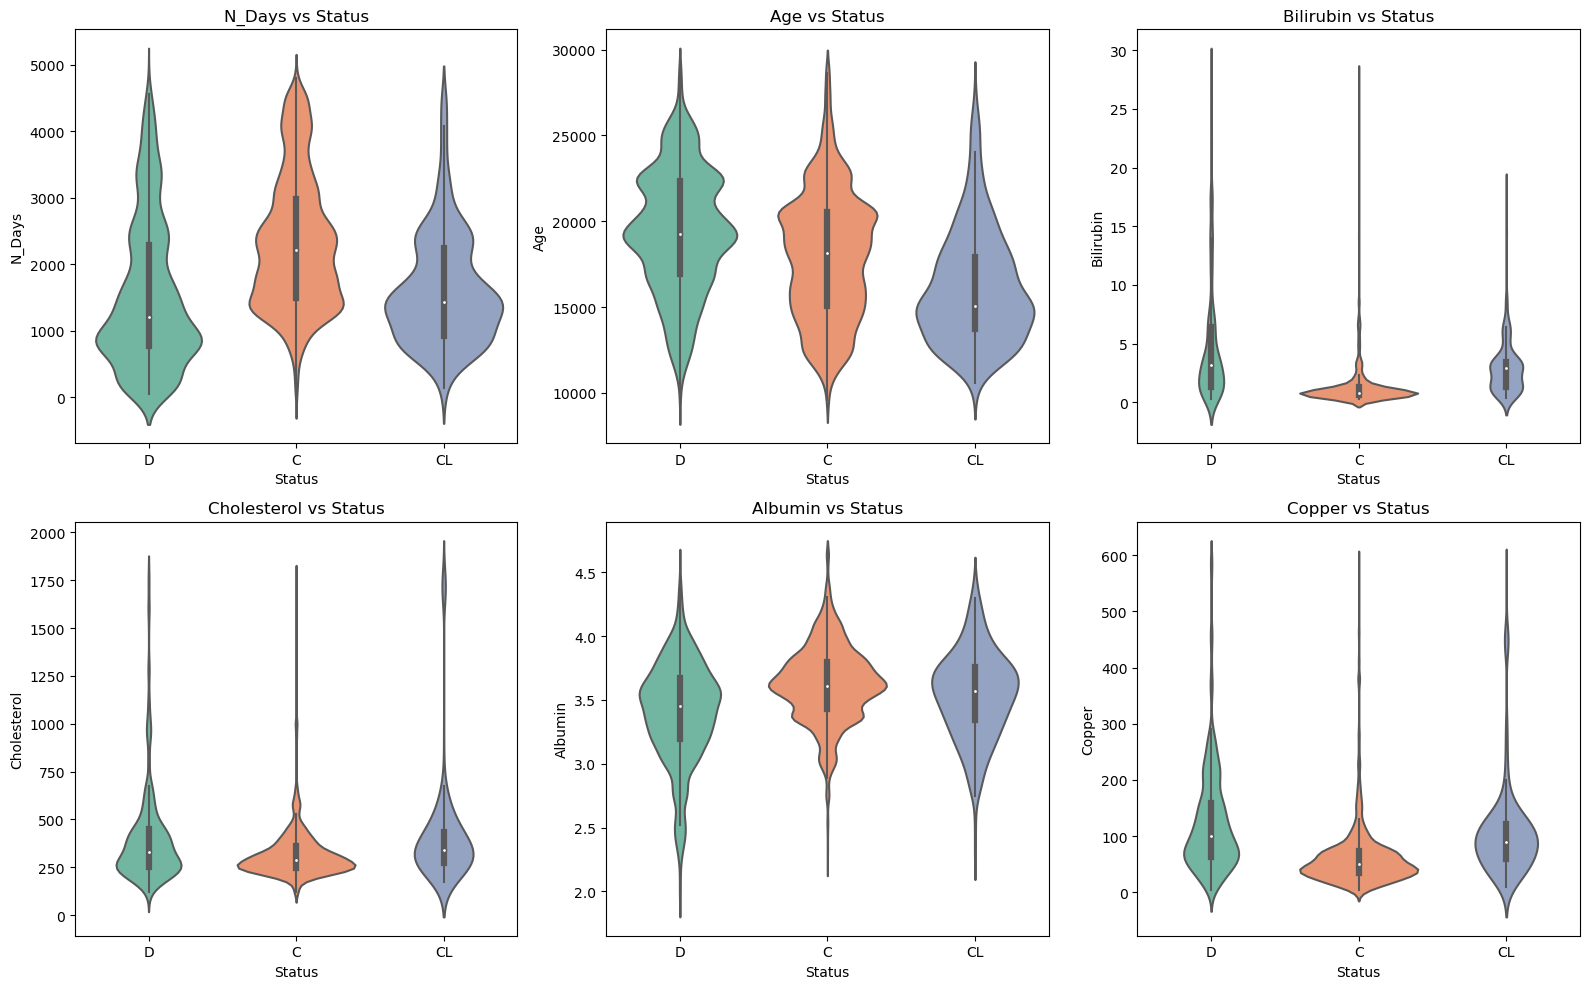

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for i, ax in enumerate(axes.flatten()):
    sns.violinplot(x=LABEL, y=NUM_FEATS[i], data=df_train, ax=ax)
    # Set x ticks to be the original labels (inverse transform)
    ax.set_title(f"{NUM_FEATS[i]} vs {LABEL}")
plt.tight_layout()
plt.show()

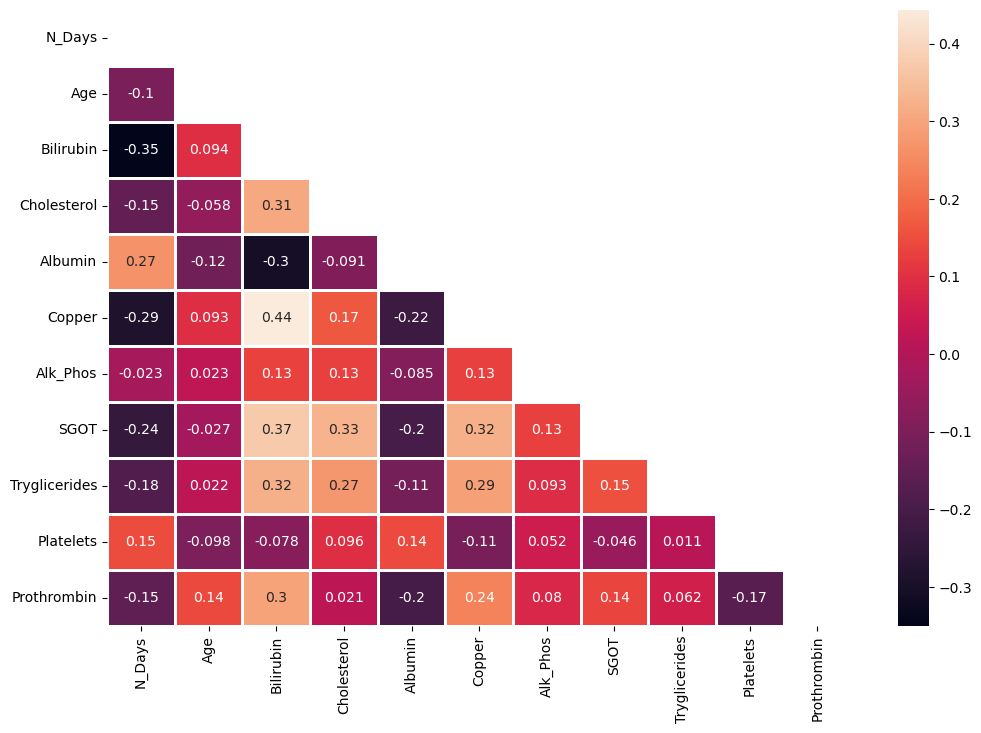

In [18]:
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(df_train[NUM_FEATS].corr(), dtype=bool))
sns.heatmap(df_train[NUM_FEATS].corr(), annot=True, mask=mask, linewidths=1)
plt.show()

C:\Users\Brett Lill\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Brett Lill\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Brett Lill\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Brett Lill\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

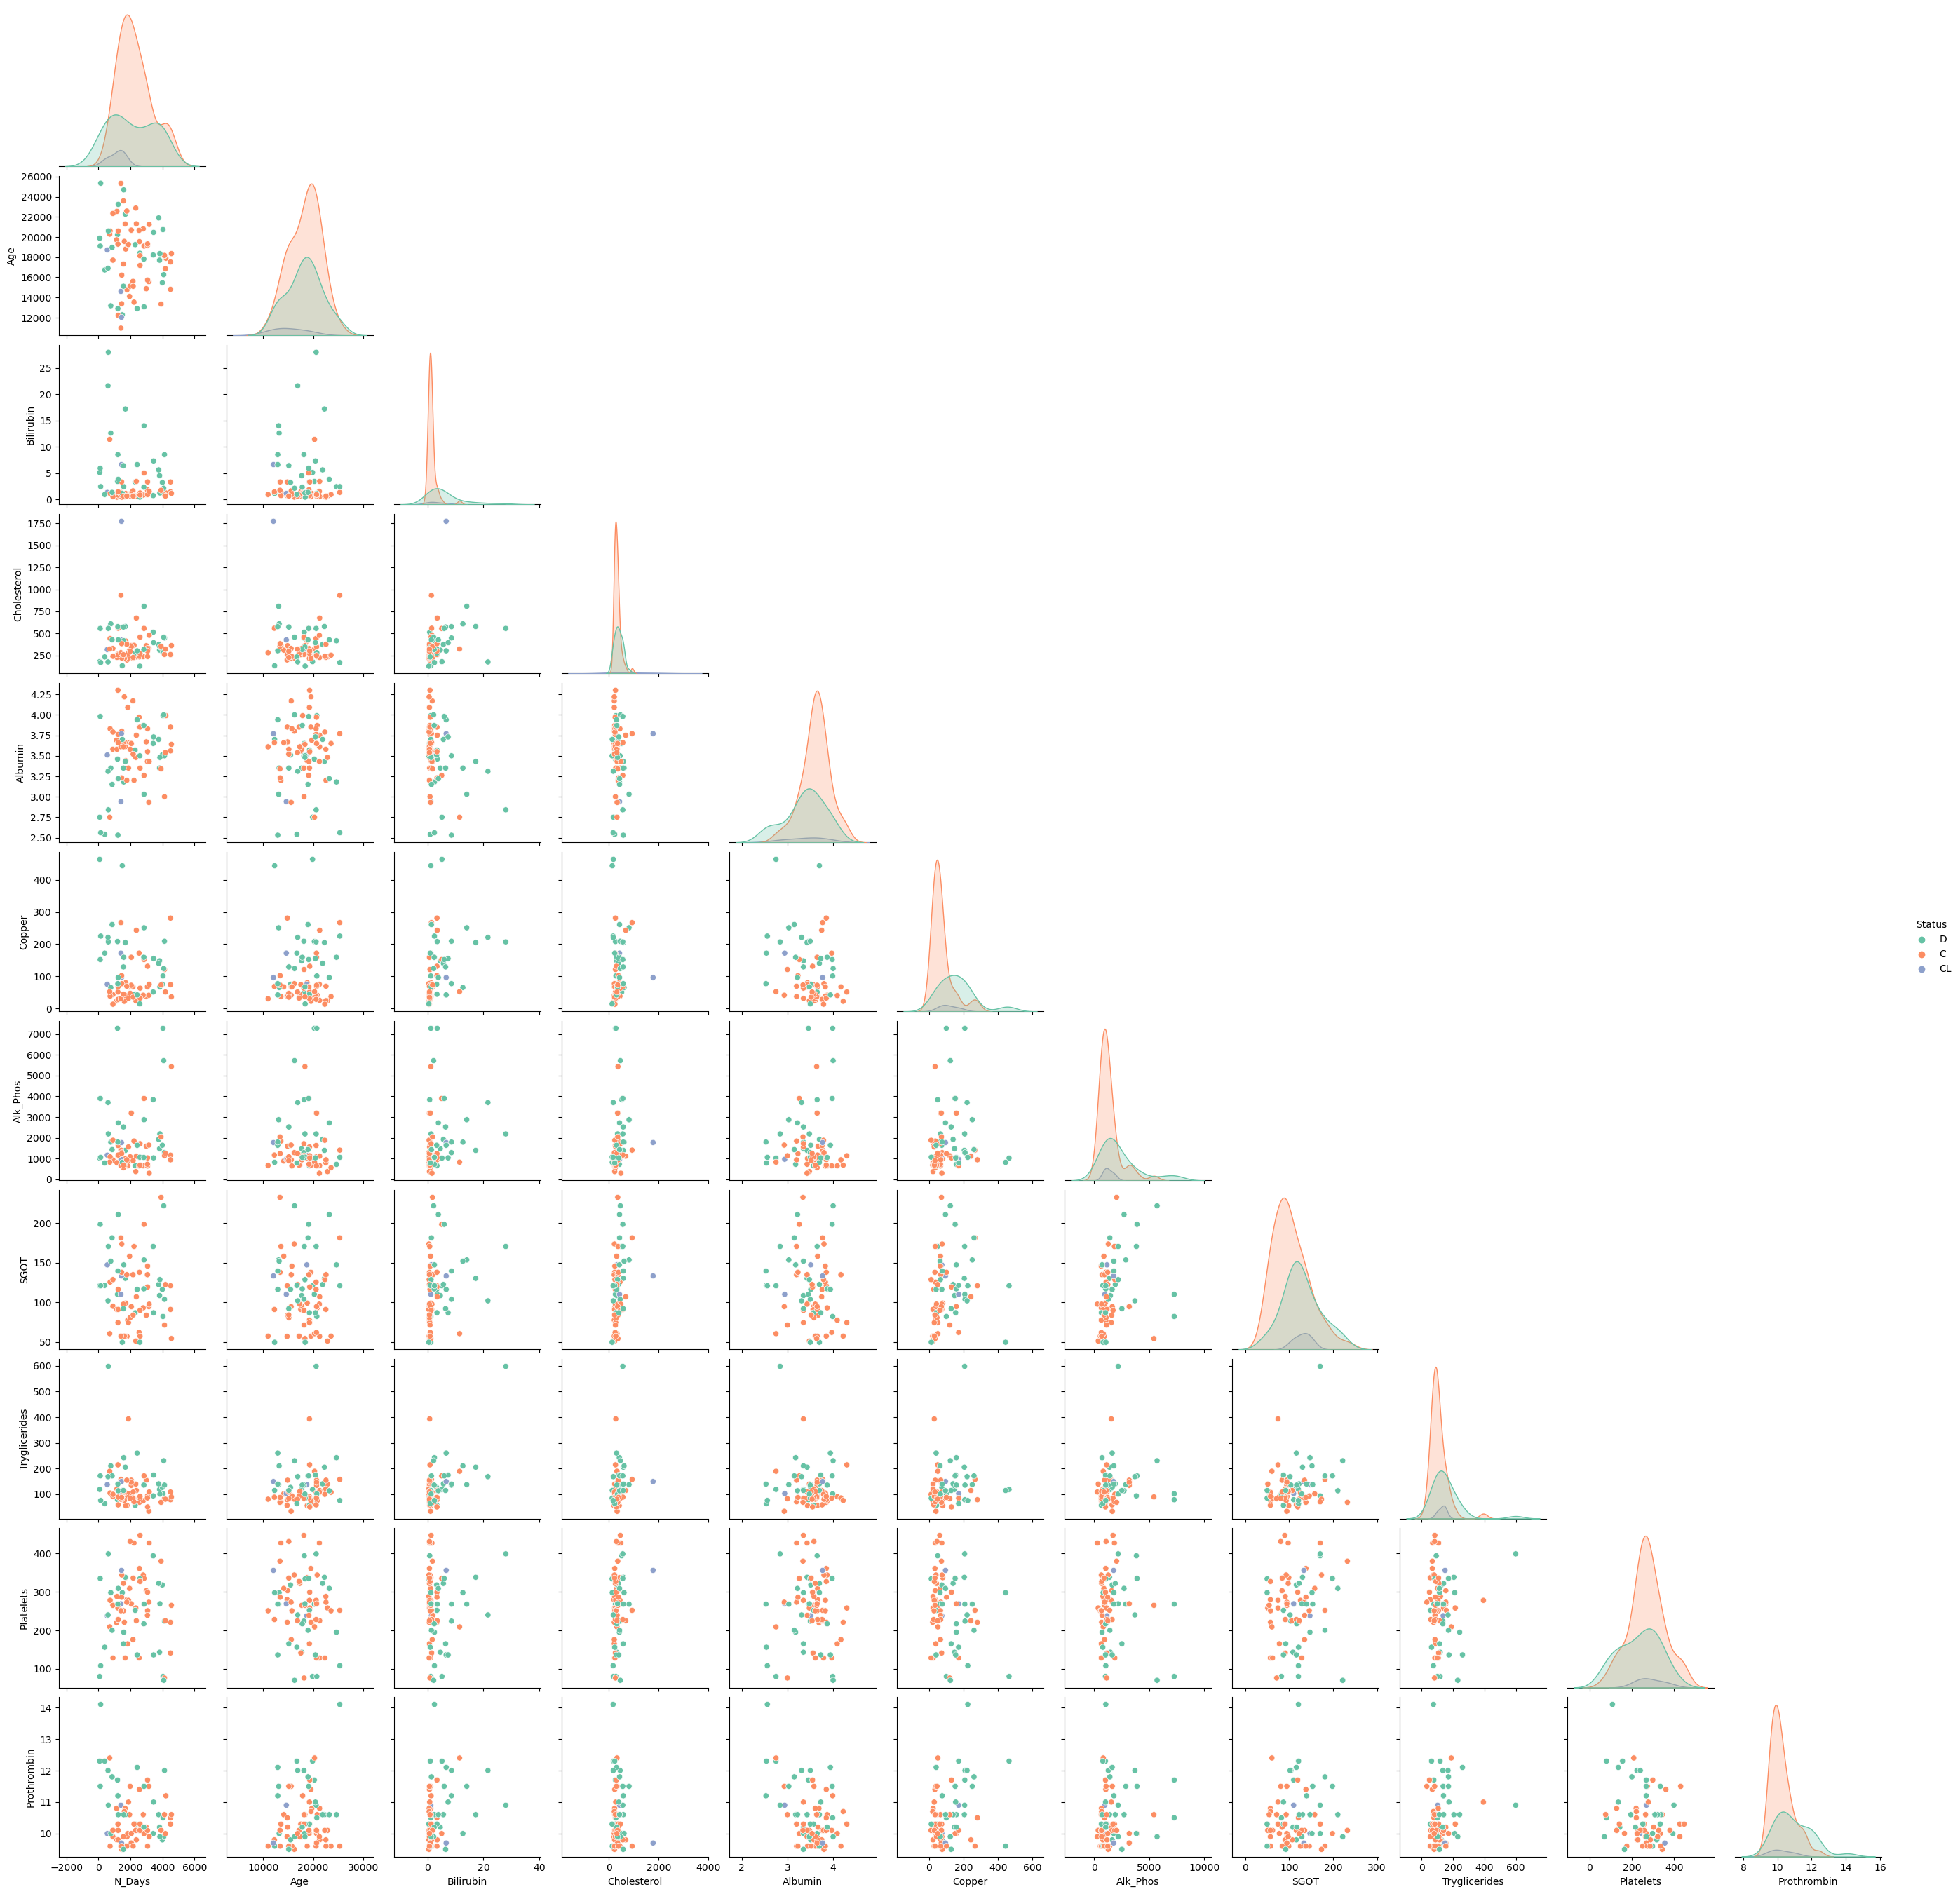

In [19]:
pairplot = sns.pairplot(df_train[NUM_FEATS + [LABEL]].sample(frac=.01), 
                 hue=LABEL, 
                 corner=True)

# Feature Engineering

In [20]:
# SET THE DATA VERSION FOR STORING DATA
DATA_VERSION = 24

CAT_FEATS = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
NUM_FEATS = [x for x in df_train.columns if x not in CAT_FEATS and x != LABEL]

# Copy dataframes and modify them
df_train_mod = df_train.copy()
df_test_mod = df_test.copy()

print(f"Train shape: {df_train_mod.shape}")
print(f"Test shape: {df_test_mod.shape}")
assert df_train_mod.shape[1]-1 == df_test_mod.shape[1]

Train shape: (8323, 19)
Test shape: (5271, 18)


## Missing values

In [21]:
# Missing categories
missing_cat=[f for f in df_train_mod.columns if df_train_mod[f].dtype=="O" if df_train_mod[f].isna().sum()>0]
train_missing_pct = df_train_mod[missing_cat].isnull().mean() * 100
test_missing_pct = df_train_mod[missing_cat].isnull().mean() * 100

missing_pct_df = pd.concat([train_missing_pct, test_missing_pct], axis=1, keys=['Train %', 'Test%'])
print(missing_pct_df)

cat_params={
            'depth': 6,
            'learning_rate': 0.1,
            'l2_leaf_reg': 0.7,
            'random_strength': 0.2,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'MultiClass',
            'loss_function': 'MultiClass',
}

def store_missing_rows(df, features):
    missing_rows = {}
    
    for feature in features:
        missing_rows[feature] = df[df[feature].isnull()]
    
    return missing_rows

def fill_missing_categorical(train, test, target, features, max_iterations=10):
    df = pd.concat([train.drop(columns=target), test], axis="rows")
    df = df.reset_index(drop=True)

    # Step 1: Store the instances with missing values in each feature
    missing_rows = store_missing_rows(df, features)

    # Step 2: Initially fill all missing values with "Missing"
    for f in features:
        df[f] = df[f].fillna("Missing_" + f)

    for iteration in tqdm(range(max_iterations), desc="Iterations"):
        for feature in features:
            # Skip features with no missing values
            rows_miss = missing_rows[feature].index

            missing_temp = df.loc[rows_miss].copy()
            non_missing_temp = df.drop(index=rows_miss).copy()
            missing_temp = missing_temp.drop(columns=[feature])

            other_features = [x for x in df.columns if x != feature and df[x].dtype == "O"]

            X_train = non_missing_temp.drop(columns=[feature])
            y_train = non_missing_temp[[feature]]

            catboost_classifier = CatBoostClassifier(**cat_params)
            catboost_classifier.fit(X_train, y_train, cat_features=other_features, verbose=False)

            # Step 4: Predict missing values for the feature and update all N features
            y_pred = catboost_classifier.predict(missing_temp)
            
            # Convert y_pred to strings if necessary
            if y_pred.dtype != "O":
                y_pred = y_pred.astype(str)

            df.loc[rows_miss, feature] = y_pred

    train[features] = np.array(df.iloc[:train.shape[0]][features])
    test[features] = np.array(df.iloc[train.shape[0]:][features])

    return train, test

               Train %     Test%
Drug          1.273579  1.273579
Ascites       1.273579  1.273579
Hepatomegaly  1.273579  1.273579
Spiders       1.273579  1.273579


In [22]:
# Missing numerical values
missing_num=[f for f in df_train_mod.columns if df_train_mod[f].dtype!="O" and df_train_mod[f].isna().sum()>0]
train_missing_pct = df_train_mod[missing_num].isnull().mean() * 100
test_missing_pct = df_test_mod[missing_num].isnull().mean() * 100
missing_pct_df = pd.concat([train_missing_pct, test_missing_pct], axis=1, keys=['Train %', 'Test%'])
print(missing_pct_df)

cb_params = {
            'iterations': 500,
            'depth': 6,
            'learning_rate': 0.02,
            'l2_leaf_reg': 0.5,
            'random_strength': 0.2,
            'max_bin': 150,
            'od_wait': 80,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'IncToDec',
            'eval_metric': 'RMSE',
            'loss_function': 'RMSE',
            'random_state': 42,
        }
lgb_params = {
            'n_estimators': 50,
            'max_depth': 8,
            'learning_rate': 0.02,
            'subsample': 0.20,
            'colsample_bytree': 0.56,
            'reg_alpha': 0.25,
            'reg_lambda': 5e-08,
            'objective': 'multiclass',
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'random_state': 42,
        }
def rmse(y1,y2):
    return(np.sqrt(mean_squared_error(y1,y2)))

def fill_missing_numerical(train,test,target, features, max_iterations=10):
    train_temp=train.copy()
    if target in train_temp.columns:
        train_temp=train_temp.drop(columns=target)
        
    
    df=pd.concat([train_temp,test],axis="rows")
    df=df.reset_index(drop=True)
    
    # Step 1: Store the instances with missing values in each feature
    missing_rows = store_missing_rows(df, features)
    
    # Step 2: Initially fill all missing values with "Missing"
    for f in features:
        df[f]=df[f].fillna(df[f].mean())
    
    cat_features=[f for f in df.columns if not pd.api.types.is_numeric_dtype(df[f])]
    dictionary = {feature: [] for feature in features}
    
    for iteration in tqdm(range(max_iterations), desc="Iterations"):
        for feature in features:
            # Skip features with no missing values
            rows_miss = missing_rows[feature].index
            
            missing_temp = df.loc[rows_miss].copy()
            non_missing_temp = df.drop(index=rows_miss).copy()
            y_pred_prev=missing_temp[feature]
            missing_temp = missing_temp.drop(columns=[feature])
            
            
            # Step 3: Use the remaining features to predict missing values using Random Forests
            X_train = non_missing_temp.drop(columns=[feature])
            y_train = non_missing_temp[[feature]]
            
            model = CatBoostRegressor(**cb_params)
#             if iteration>3:
#                 model = lgb.LGBMRegressor()
            model.fit(X_train, y_train,cat_features=cat_features, verbose=False)
            
            # Step 4: Predict missing values for the feature and update all N features
            y_pred = model.predict(missing_temp)
            df.loc[rows_miss, feature] = y_pred
            error_minimize=rmse(y_pred,y_pred_prev)
            dictionary[feature].append(error_minimize)  # Append the error_minimize value

    for feature, values in dictionary.items():
        iterations = range(1, len(values) + 1)  # x-axis values (iterations)
        plt.plot(iterations, values, label=feature)  # plot the values
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title('Minimization of RMSE with iterations')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    train[features] = np.array(df.iloc[:train.shape[0]][features])
    test[features] = np.array(df.iloc[train.shape[0]:][features])

    return train,test

                Train %  Test%
Cholesterol    1.609996    0.0
Copper         1.297609    0.0
Alk_Phos       1.273579    0.0
SGOT           1.273579    0.0
Tryglicerides  1.634026    0.0
Platelets      0.132164    0.0
Prothrombin    0.024030    0.0
Stage          0.072089    0.0


In [23]:
DROP_MISSING = True
if DROP_MISSING:
    # TODO: this is just preliminary ... not very elegant
    df_train_mod = df_train_mod.dropna()
    df_test_mod = df_test_mod.dropna()
else:
    df_train_mod, df_test_mod = fill_missing_categorical(df_train_mod, df_test_mod, LABEL, missing_cat, 5)
    df_train_mod, df_test_mod = fill_missing_numerical(df_train_mod, df_test_mod, LABEL, missing_num, 5)

## Label & Feature Encoding

In [24]:
# Encode the label
label_encoder = LabelEncoder()
df_train_mod[LABEL] = label_encoder.fit_transform(df_train_mod[LABEL])

In [25]:
encoders = {
    'Drug': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[['Placebo', 'D-penicillamine']]),
    'Sex': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Ascites': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Hepatomegaly': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Spiders': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    # 'Edema': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[['N', 'S', 'Y']]),
    'Edema': OneHotEncoder(),
    'Stage': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
}

In [26]:
for feat, enc in encoders.items():
    if isinstance(enc, OrdinalEncoder):
        df_train_mod[feat] = enc.fit_transform(df_train_mod[[feat]]).astype('int32')
        df_test_mod[feat] = enc.transform(df_test_mod[[feat]]).astype('int32')
    if isinstance(enc, OneHotEncoder):
        # Transform and get new column names
        new_cols = enc.fit_transform(df_train_mod[[feat]]).toarray().astype('int8')
        # col_names = [f"{feat}_{cat}" for cat in enc.categories_[0]]
        col_names = enc.get_feature_names_out()
        
        # Add new columns to the dataframe
        df_train_mod[col_names] = new_cols
        df_train_mod.drop(feat, axis=1, inplace=True)  # Drop original column
        
        # Repeat for the test set
        new_cols_test = enc.transform(df_test_mod[[feat]]).toarray().astype('int8')
        df_test_mod[col_names] = new_cols_test
        df_test_mod.drop(feat, axis=1, inplace=True)

# Pipeline Estimators (Creating additional features)

In [27]:
class DiagnosisDateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diagnosis_Date'] = X['Age'] - X['N_Days']
        return X
    
class AgeYearsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Age_Years'] = round(X['Age'] / 365.25).astype("int16")
        return X

class AgeGroupsTransformer(BaseEstimator, TransformerMixin):
    """Older people might be hit harder (interaction) by health issues. Also can cover lifestyle influences, i.e.
    alcohol consumption etc."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Use years from above, min=26, max=78
        X['Age_Group'] = pd.cut(X['Age_Years'], bins=[19, 29, 49, 64, 99], labels = [0, 1, 2, 3]).astype('int16')
        return X

class BilirubinAlbuminTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Bilirubin_Albumin'] = X['Bilirubin'] * X['Albumin']
        return X

class DrugEffectivenessTransformer(BaseEstimator, TransformerMixin):
    # Placeholder concept, assuming 'Bilirubin' improvement is a measure of effectiveness
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Drug_Effectiveness'] = X['Drug'] * X['Bilirubin']
        return X

class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    # From data set explanations above let's add all the "bad" symptoms
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
        symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        X['Symptom_Score'] = X[symptom_columns].sum(axis=1)
        return X
    
class SymptomCatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        self.encoder = OneHotEncoder(handle_unknown='ignore')

    def fit(self, X, y=None):
        X_copy = X.copy()
        symptom_scores = X_copy[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        self.encoder.fit(symptom_scores.values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_transformed = X.copy()
        symptom_scores = X_transformed[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        
        encoded_features = self.encoder.transform(symptom_scores.values.reshape(-1, 1)).toarray().astype("int8")
        encoded_feature_names = self.encoder.get_feature_names_out(input_features=['Symptom_Score'])

        # Drop the original symptom columns and add the new encoded features
        # X_transformed.drop(columns=self.symptom_columns, inplace=True)
        X_transformed[encoded_feature_names] = pd.DataFrame(encoded_features, index=X_transformed.index)
        
        return X_transformed


class LiverFunctionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        liver_columns = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT']
        X['Liver_Function_Index'] = X[liver_columns].mean(axis=1)
        return X

class RiskScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Risk_Score'] = X['Bilirubin'] + X['Albumin'] - X['Alk_Phos']
        return X

class TimeFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diag_Year'] = (X['N_Days'] / 365).astype(int)
        X['Diag_Month'] = ((X['N_Days'] % 365) / 30).astype(int)
        return X
    
class ScalingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_feats = NUM_FEATS + ['Diagnosis_Date', 'Age_Years', 'Bilirubin_Albumin', 'Drug_Effectiveness', 
                                      'Symptom_Score', 'Liver_Function_Index', 'Risk_Score', 'Diag_Year', 'Diag_Month']

    def fit(self, X, y=None):
        self.scaler.fit(X[self.num_feats])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.num_feats] = self.scaler.transform(X_scaled[self.num_feats])
        return X_scaled

# Define the pipeline
pipeline = Pipeline([
    ('diagnosis_date', DiagnosisDateTransformer()),
    ('age_years', AgeYearsTransformer()),
    ('age_groups', AgeGroupsTransformer()),
    ('bilirubin_albumin', BilirubinAlbuminTransformer()),
    ('drug_effectiveness', DrugEffectivenessTransformer()),
    ('symptom_score', SymptomScoreTransformer()),
    ('symptom_cat_score', SymptomCatTransformer()),
    ('liver_function', LiverFunctionTransformer()),
    ('risk_score', RiskScoreTransformer()),
    ('time_features', TimeFeaturesTransformer()),
    #('scaling', ScalingTransformer()),
    # ... ?
])

# Apply the pipeline to your dataframes
df_train_mod = pipeline.fit_transform(df_train_mod)
df_test_mod = pipeline.transform(df_test_mod)

# Update the CAT_FEATS
CAT_FEATS = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage', #old
             'Age_Group', 'Symptom_Score'] # new 
# Update the NUM_FEATS ????

## Outlier Detection

In [29]:
tmp_df = df_train_mod.copy()

# Calculate the mean and standard deviation for each column
means = tmp_df[NUM_FEATS].mean()
std_devs = tmp_df[NUM_FEATS].std()

# Define a threshold for what you consider to be an outlier, typically 3 standard deviations from the mean
n_stds = 6
thresholds = n_stds * std_devs

# Detect outliers
outliers = (np.abs(tmp_df[NUM_FEATS] - means) > thresholds).any(axis=1)

print(f"Detected {sum(outliers)} that are more than {n_stds} SDs away from mean...")

# The resulting boolean series can be used to filter out the outliers
outliers_df = tmp_df[outliers]

# Overwrite the train data
df_train_mod = tmp_df[~outliers].reset_index(drop=True)
print(f"Train data shape after outlier removal: {df_train_mod.shape}")

Detected 147 that are more than 6 SDs away from mean...
Train data shape after outlier removal: (8034, 55)


## Dimensionality Reduction

In [30]:
def tsne_with_feature_selection_and_pca(data, num_feats, target_column, n_components=2, top_n_features=10, pca_components=None):
    """
    Select top features based on feature importance, optionally apply PCA, and then use t-SNE for visualization.

    Parameters:
    data (DataFrame): The input data.
    num_feats (list): List of numerical feature column names.
    target_column (str): The name of the target column.
    n_components (int): Number of dimensions for t-SNE (2 or 3). Default is 2.
    top_n_features (int): Number of top features to select based on importance. Default is 10.
    pca_components (int or None): Number of PCA components to retain before applying t-SNE. If None, PCA is not applied.
    """
    
    global label_encoder
    
    # Standardizing the numerical features
    scaler = StandardScaler()
    numerical_data_scaled = scaler.fit_transform(data[num_feats])

    # Random Forest for feature importances
    rf = RandomForestClassifier(random_state=42)
    rf.fit(numerical_data_scaled, data[target_column])
    importances = rf.feature_importances_

    # Selecting top_n_features
    indices = np.argsort(importances)[-top_n_features:]
    selected_features = [num_feats[i] for i in indices]

    # Data for t-SNE
    tsne_data = numerical_data_scaled[:, indices]

    # Optionally applying PCA
    if pca_components is not None and pca_components < len(selected_features):
        pca = PCA(n_components=pca_components)
        tsne_data = pca.fit_transform(tsne_data)

    # Applying t-SNE
    tsne = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(tsne_data)

    # Creating a DataFrame for the t-SNE results
    tsne_df = pd.DataFrame(tsne_results, columns=[f'Component {i+1}' for i in range(n_components)])
    tsne_df[target_column] = label_encoder.inverse_transform(data[target_column].values)

    # Visualizing using Plotly
    if n_components == 3:
        fig = px.scatter_3d(tsne_df, x='Component 1', y='Component 2', z='Component 3', color=target_column)
    else:
        fig = px.scatter(tsne_df, x='Component 1', y='Component 2', color=target_column)
    
    fig.update_layout(width=800, height=600)
    fig.show()

df_train_red = df_train_mod
# tsne_with_feature_selection_and_pca(df_train_red, NUM_FEATS, LABEL, n_components=3, top_n_features=10, pca_components=None)

In [31]:
# Features to combine 
# All
#df_train_pca = df_train_mod.drop([LABEL], axis=1)
#df_test_pca = df_test_mod

# Numerical feats
df_train_pca = df_train_mod[NUM_FEATS]
df_test_pca = df_test_mod[NUM_FEATS]

# Some, the feats here are taken iteratively from previous runs
#FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days']
#PCA_FEATS = [c for c in df_train_mod.drop(LABEL, axis=1).columns.values if c not in FEATS]
#df_train_pca = df_train_mod[PCA_FEATS]
#df_test_pca = df_test_mod[PCA_FEATS]

pca = PCA(n_components=10)
df_train_pca = pca.fit_transform(df_train_pca)
df_test_pca = pca.transform(df_test_pca)

print(f"Explained variance per component: {np.round(pca.explained_variance_ratio_, 1)}")

Explained variance per component: [0.7 0.2 0.1 0.  0.  0.  0.  0.  0.  0. ]


In [32]:
eps_expl_var_treshold = 0
n_pcas = np.sum(np.round(pca.explained_variance_ratio_, 3) > eps_expl_var_treshold)
pca_c_names = [f"PCA_{i}" for i in range(n_pcas)]
print(f"PCA column names: {pca_c_names}")
df_train_mod[pca_c_names] = df_train_pca[:,0:n_pcas]
df_test_mod[pca_c_names] = df_test_pca[:,0:n_pcas]

PCA column names: ['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3']


## Store Feature Engineering Results

In [33]:
# Store modified (not resampled)
df_train_mod.to_csv(f"train_mod_v{DATA_VERSION}.csv")
df_test_mod.to_csv(f"test_mod_v{DATA_VERSION}.csv")

# Model Selection

In [34]:
#from sklearn.feature_selection import RFECV

#df_feat_sel_train = df_train_mod
#feat_sel_model = xgb.XGBClassifier()
#rfe = RFECV(estimator=feat_sel_model, min_features_to_select=1, step=1, n_jobs=-1, verbose=1)

# Preliminary, should be done of course in a train-val loop
#rfe.fit(df_feat_sel_train.drop(LABEL, axis=1), df_feat_sel_train[LABEL])

#print("Feature Ranking: ", rfe.ranking_)
#rfe.transform(df_feat_sel_train.drop(LABEL, axis=1))

#sel_feats = df_feat_sel_train.drop(LABEL, axis=1).columns[rfe.support_].values
#print(len(sel_feats))
#print(sel_feats.tolist())

In [35]:
#import statsmodels.api as sm

#feat_check_model = sm.MNLogit(df_train_mod[LABEL], df_train_mod[['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age'] + pca_c_names])
#res = feat_check_model.fit()
#print(res.summary())

In [36]:
# All
# FEATS = df_train_mod.drop(LABEL, axis=1).columns.tolist()
# Some
FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 
         'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage', 'Drug', 
         'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y']
# FEATS = FEATS + pca_c_names
# FEATS = sel_feats.tolist()
print(f"Number of feats: {len(FEATS)}")
print(f"Features used: {FEATS}")

# Local optuna optimization test (cross val score: .4129666179319006), 21 FEATS
xgb_params = {'objective': 'multi_logloss', 'early_stopping_rounds': 50, 'max_depth': 9, 'min_child_weight': 8, 'learning_rate': 0.0337716365315986, 'n_estimators': 733, 'subsample': 0.6927955384688348, 'colsample_bytree': 0.1234702658812108, 'reg_alpha': 0.18561628377665318, 'reg_lambda': 0.5565488299127089, 'random_state': 42}

Number of feats: 21
Features used: ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage', 'Drug', 'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y']


In [37]:
# Just use the selected features
df_train_final = df_train_mod[FEATS + [LABEL]]
df_test_final = df_test_mod[FEATS]

# Model Selection

In [38]:
def validate_models(models: list[dict],
                    data: pd.DataFrame, 
                    label=LABEL,
                    n_splits=5,
                    n_repeats=1,
                    seed=43):
    """Run models and test them on validation sets. The optimal parameters 
    should be retrieved from previous runs e.g. GridSearchCV etc."""
    
    # TODO: the model dicts should contain the FEATS (since different FEATS should be used)
    
    train_scores, val_scores = {}, {}
    
    pbar = tqdm(models)
    for model in pbar:
        
        # Model needs to be a dict (before tuple) since I need a mutable datatype
        # to insert the average validation score in the end
        model_str = model["name"]
        model_est = model["model"]
        model_feats = model["feats"]
        
        pbar.set_description(f"Processing {model_str}...")
        
        train_scores[model_str] = []
        val_scores[model_str] = []
    
        # I think I should drop the seed when I blend the models together
        # -> they will be trained on different datasets
        skf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

        for i, (train_idx, val_idx) in enumerate(skf.split(data[model_feats], data[label])):
            pbar.set_postfix_str(f"Fold {i+1}/{n_splits}")
            
            X_train, y_train = data[model_feats].loc[train_idx], data[label].loc[train_idx]
            X_val, y_val = data[model_feats].loc[val_idx], data[label].loc[val_idx]
            
            if model_str in ["lgb_cl"]:
                callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
                model_est.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=callbacks)
            elif model_str in ["xgb_cl", "cat_cl"]:
                model_est.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)
            elif model_str in ["voting_clf"]:
                pass # TODO: find a solution
            else:
                model_est.fit(X_train, y_train)
                
            train_preds = model_est.predict_proba(X_train[model_feats])
            valid_preds = model_est.predict_proba(X_val[model_feats])
            train_score = log_loss(y_train, train_preds)
            val_score = log_loss(y_val, valid_preds)
            train_scores[model_str].append(train_score)
            val_scores[model_str].append(val_score)
            
            #print(f"{model_str} | Fold {i + 1} | " +
            #      f"Train log_loss: {round(train_score, 4)} | " +
            #      f"Valid log_loss: {round(val_score, 4)}")
        
        model["avg_val_score"] = np.mean(val_scores[model_str])
            
    return models, pd.DataFrame(train_scores), pd.DataFrame(val_scores)

In [39]:
%%time

xgb_cl = xgb.XGBClassifier(**xgb_params)

models = [
    {"name": "xgb_cl", "model": xgb_cl, "feats": FEATS},
]

models, train_scores, val_scores = validate_models(models=models, 
                                                   data=df_train_final, 
                                                   n_splits=10,
                                                   n_repeats=1)

Processing xgb_cl...: 100%|████████████████████████████████████████████████████████████| 1/1 [00:53<00:00, 53.32s/it, Fold 10/10]

Wall time: 53.3 s


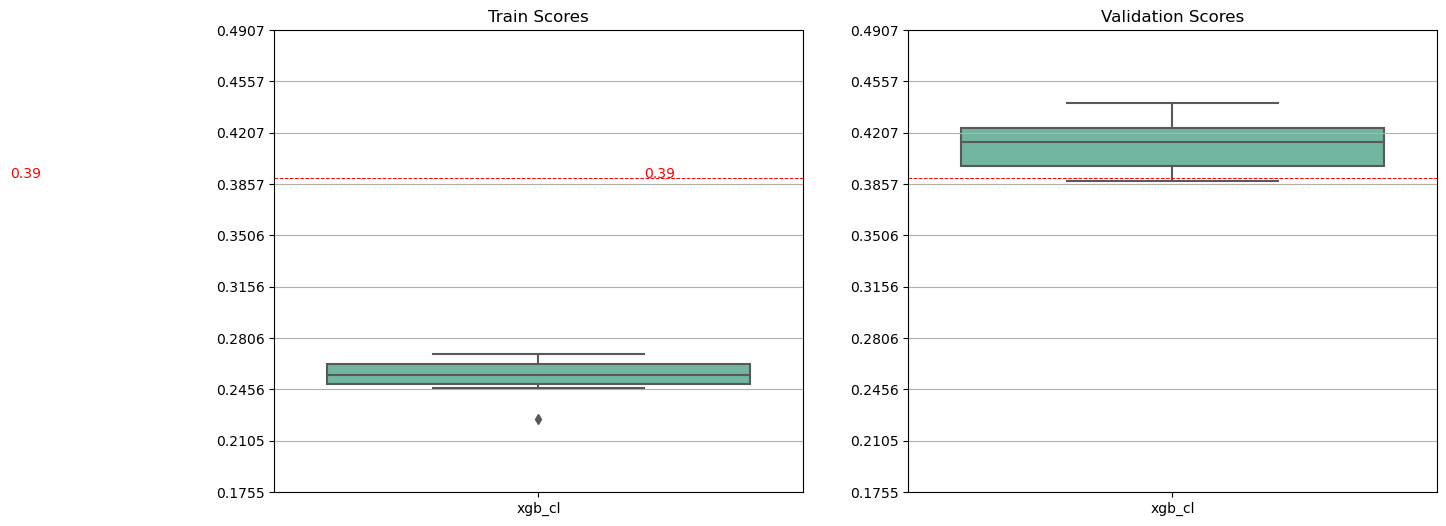

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

eps = .05
hl = .39
min_score = train_scores.min().min()-eps
max_score = val_scores.max().max()+eps

def calculate_ticks(min_score, max_score, num_ticks=10):
    return np.linspace(min_score, max_score, num_ticks)

ticks = calculate_ticks(min_score, max_score)

_ = sns.boxplot(train_scores, ax=axes[0])
_ = axes[0].set_title('Train Scores')
_ = axes[0].set_ylim(min_score, max_score)
_ = axes[0].set_yticks(ticks)
_ = axes[0].yaxis.grid(True)
_ = axes[0].axhline(y=hl, color='r', linestyle='--', lw=.7)
_ = axes[0].text(-1, hl, f"{hl}", c="red")

_ = sns.boxplot(val_scores, ax=axes[1])
_ = axes[1].set_title('Validation Scores')
_ = axes[1].set_ylim(min_score, max_score)
_ = axes[1].set_yticks(ticks)
_ = axes[1].yaxis.grid(True)
_ = axes[1].axhline(y=hl, color='r', linestyle='--', lw=.7)
_ = axes[1].text(-1, hl, f"{hl}", c="red")

           Train  Validation
count  10.000000   10.000000
mean    0.254641    0.411888
std     0.012971    0.016980
min     0.225525    0.387990
25%     0.249377    0.398302
50%     0.255475    0.414575
75%     0.263279    0.423747
max     0.270001    0.440746


C:\Users\Brett Lill\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Brett Lill\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


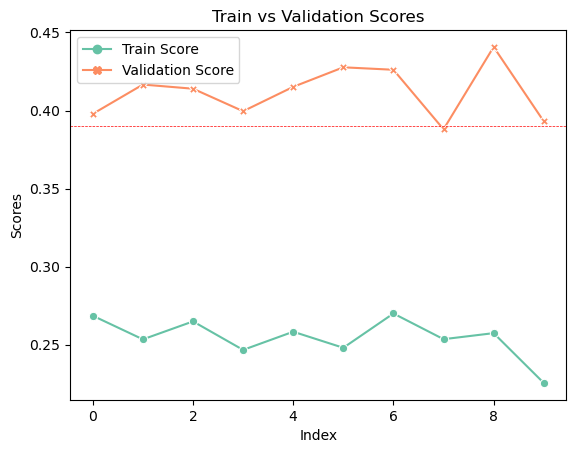

In [41]:
# Print results in DataFrame
model_res = pd.concat([train_scores.describe(), val_scores.describe()], axis=1)
model_res.columns = ['Train', 'Validation']
print(model_res)

# Plot results as lineplot
_ = sns.lineplot(pd.concat([train_scores, val_scores], keys=["Train Score", "Validation Score"], axis=1), markers=True, dashes=False)
plt.axhline(y=0.39, color='r', linestyle='--', lw=.5)
plt.title('Train vs Validation Scores')
plt.xlabel('Index')
plt.ylabel('Scores')
plt.show()

# Model Evaluation

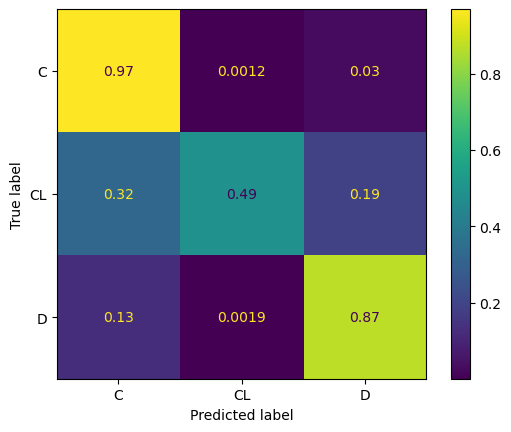

In [43]:
model_fin = models[0]['model']

y_hat = model_fin.predict(df_train_final[FEATS])
ConfusionMatrixDisplay.from_predictions(df_train_final[LABEL], y_hat, normalize='true', display_labels=label_encoder.classes_)
plt.show()

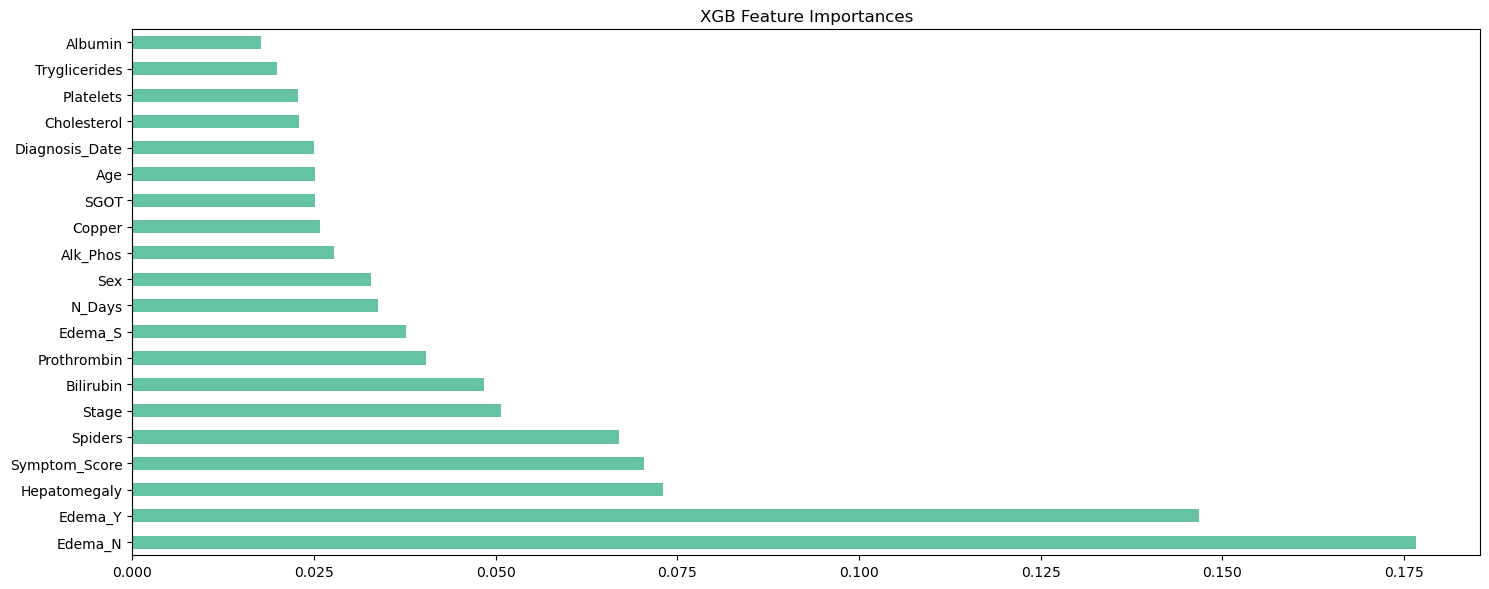

Total sorted XGBClassifier importances: ['Edema_N', 'Edema_Y', 'Hepatomegaly', 'Symptom_Score', 'Spiders', 'Stage', 'Bilirubin', 'Prothrombin', 'Edema_S', 'N_Days', 'Sex', 'Alk_Phos', 'Copper', 'SGOT', 'Age', 'Diagnosis_Date', 'Cholesterol', 'Platelets', 'Tryglicerides', 'Albumin', 'Drug']


In [44]:
# Creating Pandas Series for feature importances
xgb_feat_importances = pd.Series(xgb_cl.feature_importances_, index=df_train_final[FEATS].columns)

# Plotting both feature importances in subplots
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

xgb_feat_importances.nlargest(20).plot(kind='barh', title='XGB Feature Importances')

plt.tight_layout()
plt.show()
print(f"Total sorted XGBClassifier importances: {xgb_feat_importances.nlargest(99).index.tolist()}")

# Submission

In [45]:
y_test_hat = model_fin.predict_proba(df_test_final[FEATS])
assert y_test_hat.shape == (df_test.shape[0], 3)

In [46]:
submission_labels = ["Status_C", "Status_CL", "Status_D"]

sub = pd.DataFrame(
    {"id": test_IDs, **dict(zip(submission_labels, y_test_hat.T))}
)
sub.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.358405,0.019214,0.622381
1,7906,0.368121,0.260779,0.371099
2,7907,0.035592,0.006912,0.957496
3,7908,0.974742,0.003745,0.021513
4,7909,0.906578,0.048837,0.044585


In [48]:
sub.to_csv("Submission_v1.csv", index = False)